In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent
from collections import Counter
import itertools
import matplotlib

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

In [8]:
chr11 = '/nfs/kitzman2/lab_common2/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 'chr11' ]

In [9]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'
refseq = pp.get_refseq( fa_file )[ 'jkp1053_1054_1055' ]

In [10]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [11]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

In [12]:
tab20 = cm.get_cmap('tab20c' )
new_tab = [ tab20( i ) for i in range( 0, 16, 4 ) ] 
tab_sdv = ListedColormap( new_tab )
new_tab = [ tab20( i ) for i in range( 2, 18, 4 ) ] 
tab_intmed = ListedColormap( new_tab )

In [13]:
dark = cm.get_cmap('Dark2' )

In [14]:
plot_out = '/nfs/kitzman2/smithcat/proj/wt1_2022/plots/'

In [15]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [16]:
byvartbl_long = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs-2022-1018.txt' )

In [17]:
byvartbl_wide = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs_wide-2022-1018.txt' )

In [18]:
byvartbl_wide[ 'maxent_acc_diff' ] = byvartbl_wide.maxent_acc - byvartbl_wide.loc[ byvartbl_wide.pos == 1267 ].maxent_wt_acc.mean()

In [19]:
byvartbl_wide[ 'maxent_KTS-_diff' ] = byvartbl_wide[ 'maxent_KTS-' ] - byvartbl_wide.loc[ byvartbl_wide.pos == 1350 ].maxent_wt_don.mean()

In [20]:
byvartbl_wide[ 'maxent_KTS+_diff' ] = byvartbl_wide[ 'maxent_KTS+' ] - byvartbl_wide.loc[ byvartbl_wide.pos == 1359 ].maxent_wt_don.mean()

In [21]:
#hoping to preserve those missing values this time
byvartbl_wide[ 'maxent_diff' ] = byvartbl_wide[ [ 'maxent_acc_diff', 'maxent_KTS-_diff', 'maxent_KTS+_diff' ] ].sum( axis = 1, min_count = 1 )

In [22]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.final.txt

In [23]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [24]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [25]:
isos_df = pd.read_table( bdout + 'wt1_ex9_isoforms_2022-0915.txt' )

In [26]:
isos_df = isos_df[ [ col for col in isos_df if any( samp in col for samp in byvartbl_long[ 'sample' ].unique() ) or '_' not in col ] ].copy()

In [27]:
total_cols = [ 'total_read_count', 'total_num_bcs', 'total_sum_sa_reads', 'total_num_vars', 'total_passfilt' ]

for col in total_cols:
    
    if 'filt' not in col:
    
        isos_df[ col ] = isos_df[ [ lcol for lcol in isos_df if col.replace( 'total', '' ) in lcol ] ].sum( axis = 1 )
        
    else:
        
        isos_df[ col ] = isos_df[ [ lcol for lcol in isos_df if lcol.endswith( '_filter' ) ] ].sum( axis = 1 )

In [28]:
reads_df = pd.read_table( bdout + 'wt1_ex9_read_cnts_2022-0915.txt' )

In [29]:
byvartbl_wide_sat = pp.saturate_variants( byvartbl_wide,
                                         chr11_seq,
                                         'hg19_pos',
                                          'exon_num',
                                          rev_strand = True )[ 9 ]

In [30]:
#plots get messed up without the vector position included
byvartbl_wide_sat[ 'pos' ] = byvartbl_wide_sat.hg19_pos - 32412079 - 2*( byvartbl_wide_sat.hg19_pos - byvartbl_wide_sat.hg19_pos.min() )

In [31]:
byvartbl_wide_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_wide_sat.pos,
                                                     ( 1058, 1554 ),
                                                    [ (1267, 1359) ],
                                                    [ ( 1355, 1447 ), ]
                                                    )

In [32]:
FS_vars = [ 'c.1447+6:T>A', 'c.1447+5:G>A', 'c.1447+5:G>T', 'c.1447+4:C>T', 'c.1447+3:G>T', 'c.1447+2:T>C', 'c.1447+1:G>A' ]

In [33]:
byvartbl_wide[ 'lit_var_FS' ] = [ var in FS_vars for var in byvartbl_wide.hgvs_var ]

In [34]:
byvartbl_wide[ 'lit_var_FSGS' ] = [ var == 'c.1447+1:G>C' for var in byvartbl_wide.hgvs_var ]

Introduction

In [35]:
( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ).sum()

8

In [36]:
#93 exonic bp + 40 bp of flanking intron on each side
93*3 + 40*3 + 40*3

519

In [37]:
( ( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) & ( byvartbl_wide.sdv ) ).sum()

8

In [38]:
( ( byvartbl_wide.sdv ) & ~( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) ).sum()

49

In [39]:
byvartbl_wide.loc[ byvartbl_wide.sdv ][ [ 'hgvs_var', 'var_consequence', 'clinvar_interp', 'clinvar_dx', 'acmg_interp', 'Human disease reported in HGMD', 'sdv', 'wmean_KTS_+_ratio_log2' ] ]

,hgvs_var,var_consequence,clinvar_interp,clinvar_dx,acmg_interp,Human disease reported in HGMD,sdv,wmean_KTS_+_ratio_log2
99,c.1447+7:A>C,intronic,NaN,NaN,NaN,NaN,True,-1.394563
101,c.1447+7:A>T,intronic,NaN,NaN,NaN,NaN,True,-1.107780
102,c.1447+6:T>A,intronic,Pathogenic,Frasier_syndrome,NaN,NaN,True,-2.581090
103,c.1447+6:T>C,intronic,NaN,NaN,NaN,NaN,True,-2.476560
104,c.1447+6:T>G,intronic,NaN,NaN,NaN,NaN,True,-2.638910
105,c.1447+5:G>A,intronic,Pathogenic,('Frasier_syndrome|Wilms_tumor_1|11p_partial_m...,NaN,NaN,True,-2.508654
106,c.1447+5:G>C,intronic,NaN,NaN,NaN,NaN,True,-2.696274
107,c.1447+5:G>T,intronic,NaN,NaN,Pathogenic,Frasier syndrome,True,-2.693668
108,c.1447+4:C>A,intronic,NaN,NaN,NaN,NaN,True,2.278248
109,c.1447+4:C>G,intronic,NaN,NaN,NaN,NaN,True,-1.143872


Methods

In [40]:
#8 HEK samples and 2 COS-7 samples
byvartbl_long[ 'sample' ].unique()

array(['BB_RT_1_340_243_Hek1053', 'BB_RT_3_340_243_Hek1055',
       'BB_RT_2_340_243_Hek1054', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_3_340_243_Cos1055',
       'BB_RT_2_ODT_243_Hek1054', 'BB_RT_1b_340_243_Hek1053',
       'BB_RT_3_ODT_243_Cos1055', 'BB_RT_3_ODT_243_Hek1055'], dtype=object)

In [41]:
#this removes the QC metrics
isos_df = isos_df.loc[ isos_df.isoform.str.contains( '\(' ) ].copy()

In [42]:
isos_df_filt = isos_df.loc[ isos_df.total_passfilt > 0 ].copy()

In [43]:
#kts+
100*( isos_df_filt.loc[ isos_df_filt.isonum == 'iso2615' ].total_read_count / isos_df_filt.total_read_count.sum() )

2615    42.593754
Name: total_read_count, dtype: float64

In [44]:
#kts-
100*( isos_df_filt.loc[ isos_df_filt.isonum == 'iso1347' ].total_read_count / isos_df_filt.total_read_count.sum() )

1347    37.430054
Name: total_read_count, dtype: float64

In [45]:
#skip
100*( isos_df_filt.loc[ isos_df_filt.isonum == 'iso4729' ].total_read_count / isos_df_filt.total_read_count.sum() )

4729    19.092936
Name: total_read_count, dtype: float64

In [46]:
#other
100 - ( 42.593754 + 37.430054 + 19.092936 )

0.8832559999999887

In [47]:
#all sdvs replicate in at least half of the samples
( ( byvartbl_wide.sdv ) & ( byvartbl_wide.sdv_sum < ( len( byvartbl_long[ 'sample' ].unique() ) / 2 ) ) ).sum()

0

Results

In [48]:
indiv_trans_d = { 'variant': [ 'WT', '+1G>A', '+1G>C', '+2T>C', '+4C>T', '+5G>A', '+6T>A' ],
                  '+KTS': [ 2020, 0, 0, 0, 336, 0, 0 ],
                  '-KTS': [ 2386, 12451, 4760, 13582, 10603, 15955, 3717 ], }

In [49]:
indiv_trans = pd.DataFrame( indiv_trans_d )

In [50]:
indiv_trans[ '%+KTS' ] = 100*( indiv_trans[ '+KTS' ] / ( indiv_trans[ '+KTS' ] + indiv_trans[ '-KTS' ] ) )

In [51]:
indiv_trans[ '%-KTS' ] = 100*( indiv_trans[ '-KTS' ] / ( indiv_trans[ '+KTS' ] + indiv_trans[ '-KTS' ] ) )

In [52]:
indiv_trans[ 'KTS_ratio' ] = indiv_trans[ '-KTS' ] / indiv_trans[ '+KTS' ]

In [53]:
indiv_trans.loc[ indiv_trans.variant == 'WT' ].KTS_ratio

0    1.181188
Name: KTS_ratio, dtype: float64

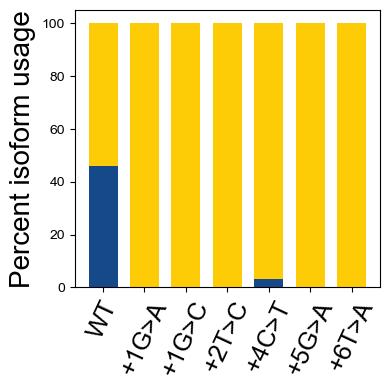

In [54]:
plt.figure( figsize = ( 4, 4 ) )

plt.bar( indiv_trans.variant,
         indiv_trans[ '%+KTS' ],
         width = .7,
         color = '#16498A' )

plt.bar( indiv_trans.variant,
         indiv_trans[ '%-KTS' ],
         width = .7,
         color = '#FECB07',
         bottom = indiv_trans[ '%+KTS' ] )

plt.ylabel( 'Percent isoform usage',
            fontsize = 20 )

plt.xticks( rotation = 65,
            fontsize = 18 )

plt.tight_layout()

plt.savefig( plot_out + 'indiv_transfection_barplot.pdf' )

plt.show()

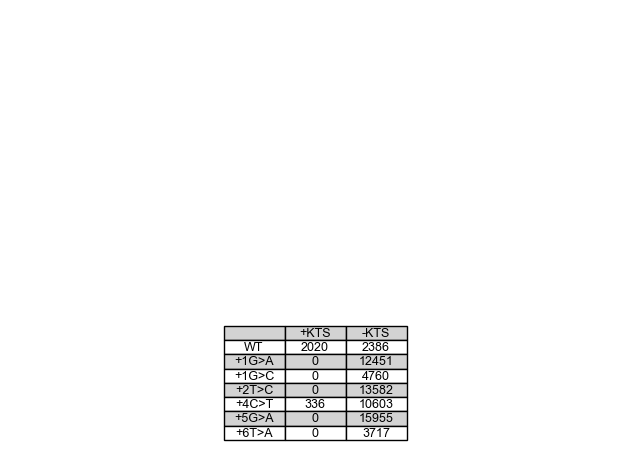

In [55]:
fig, ax = plt.subplots()
#figsize = ( 4, 12 )

alternating_colors = [ [ 'white' ] * 3, [ 'lightgray' ] * 3 ] * len( indiv_trans )
alternating_colors = alternating_colors[ : len( indiv_trans ) ]

# hide axes
fig.patch.set_visible( False )
ax.axis( 'off' )
ax.axis( 'tight' )

ax.table( cellText = indiv_trans[ [ 'variant', '+KTS', '-KTS' ] ].values, 
          colLabels = [ '', '+KTS', '-KTS' ], 
          cellLoc = 'center',
          cellColours = alternating_colors,
          colColours = [ 'lightgray' ]*3,
          colWidths = [ .1 ]*3,
          edges = 'closed' )

fig.tight_layout()

plt.savefig( plot_out + 'indiv_transfection_tbl.pdf' )

plt.show()

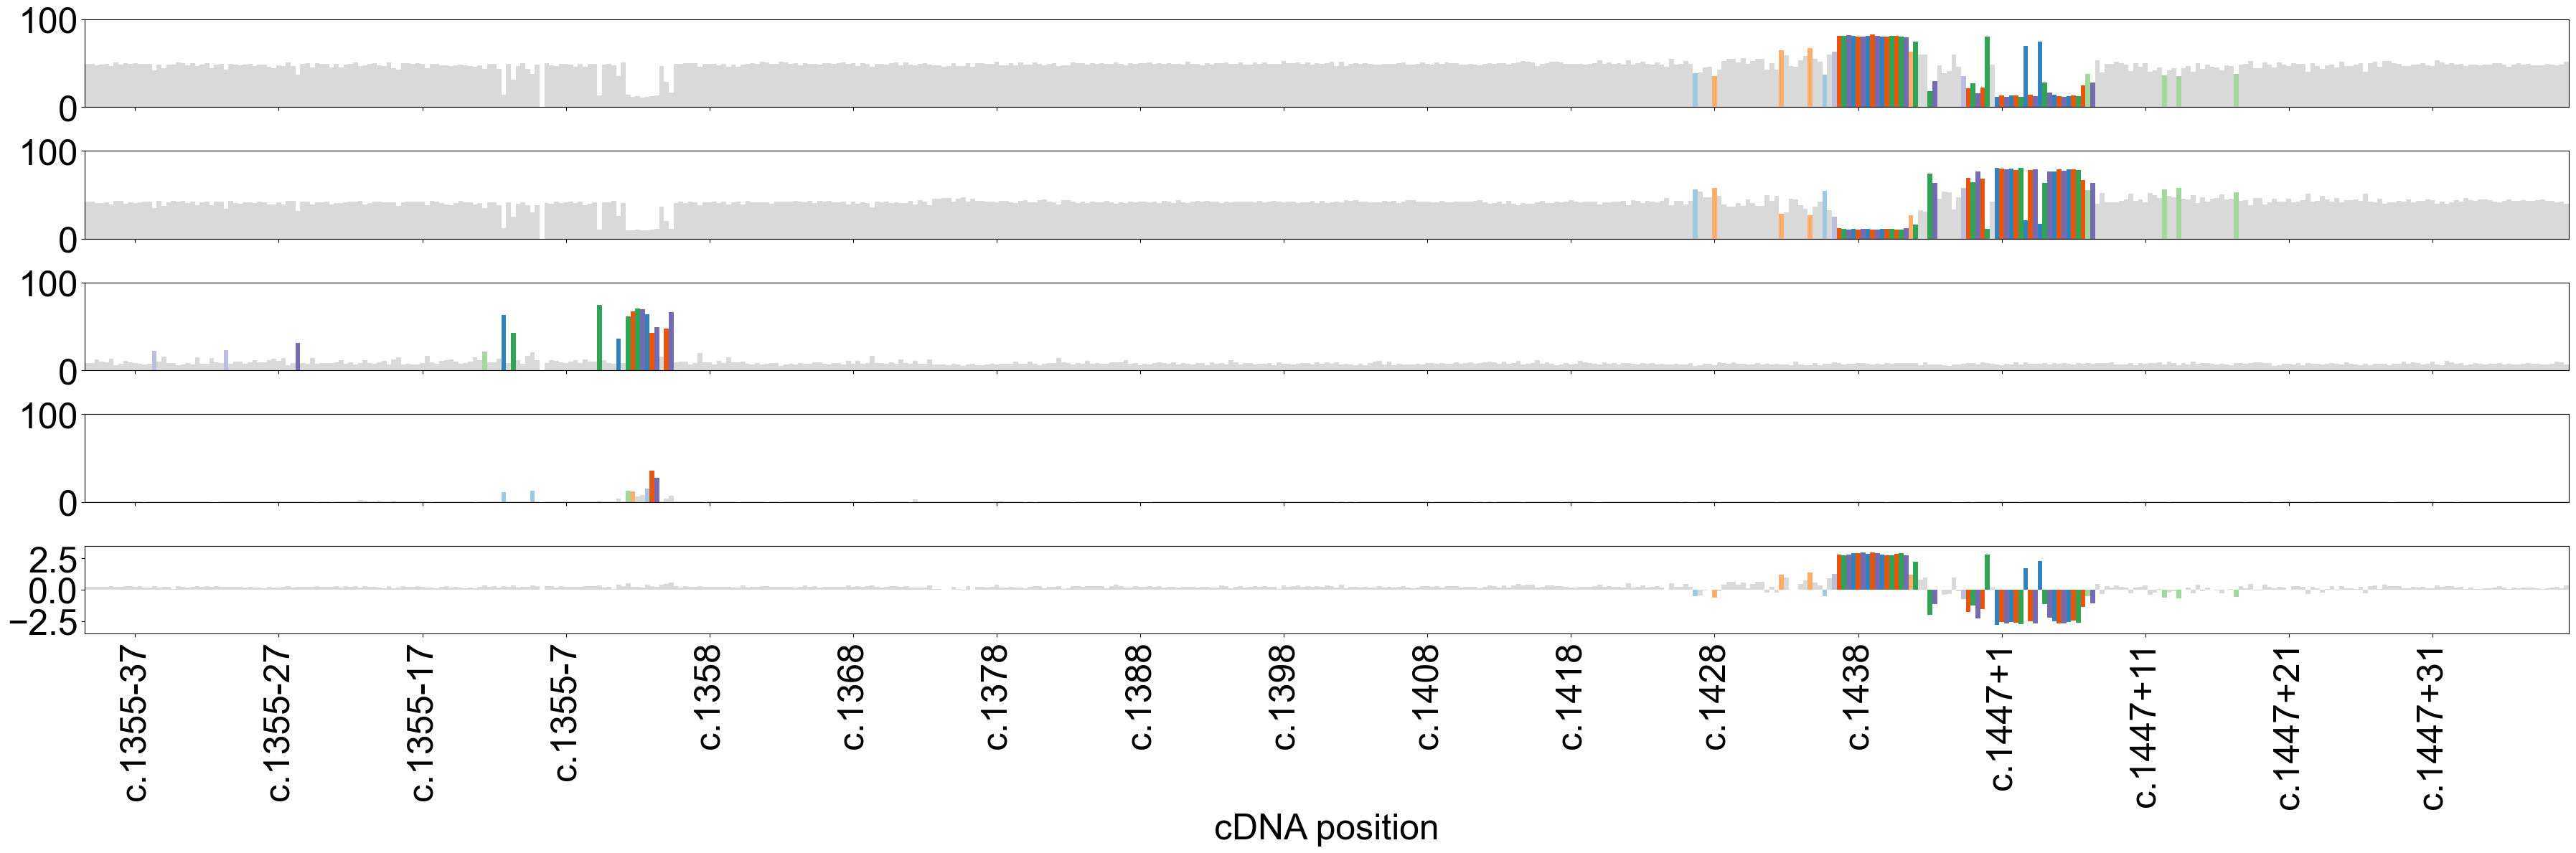

In [56]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'wmean_SKIP_100', 'wmean_OTHER_100', 'wmean_KTS_+_ratio_log2' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 36, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ) ],
                          y_ax_title = [ '', '', '', '', '' ], 
                          x_ax_title = 'cDNA position',
                          tick_spacing = 10,
                          #hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          savefile = plot_out + 'full_psi_track.pdf'
                     )

In [57]:
byvartbl_wide.sdv.sum()

57

In [58]:
byvartbl_wide.sdv.sum() / len( byvartbl_wide )

0.11003861003861004

In [59]:
byvartbl_wide.intmed.sum()

16

In [60]:
byvartbl_wide.intmed.sum() / len( byvartbl_wide )

0.03088803088803089

In [61]:
len( byvartbl_wide )

518

In [62]:
#length of +KTS exon + flanking introns
( 93 + 2*40 )*3

519

In [63]:
len( byvartbl_wide ) / ( ( 93 + 2*40 )*3 )

0.9980732177263969

In [64]:
byvartbl_wide.n_bc_passfilt_mean.mean()

79.7492277992278

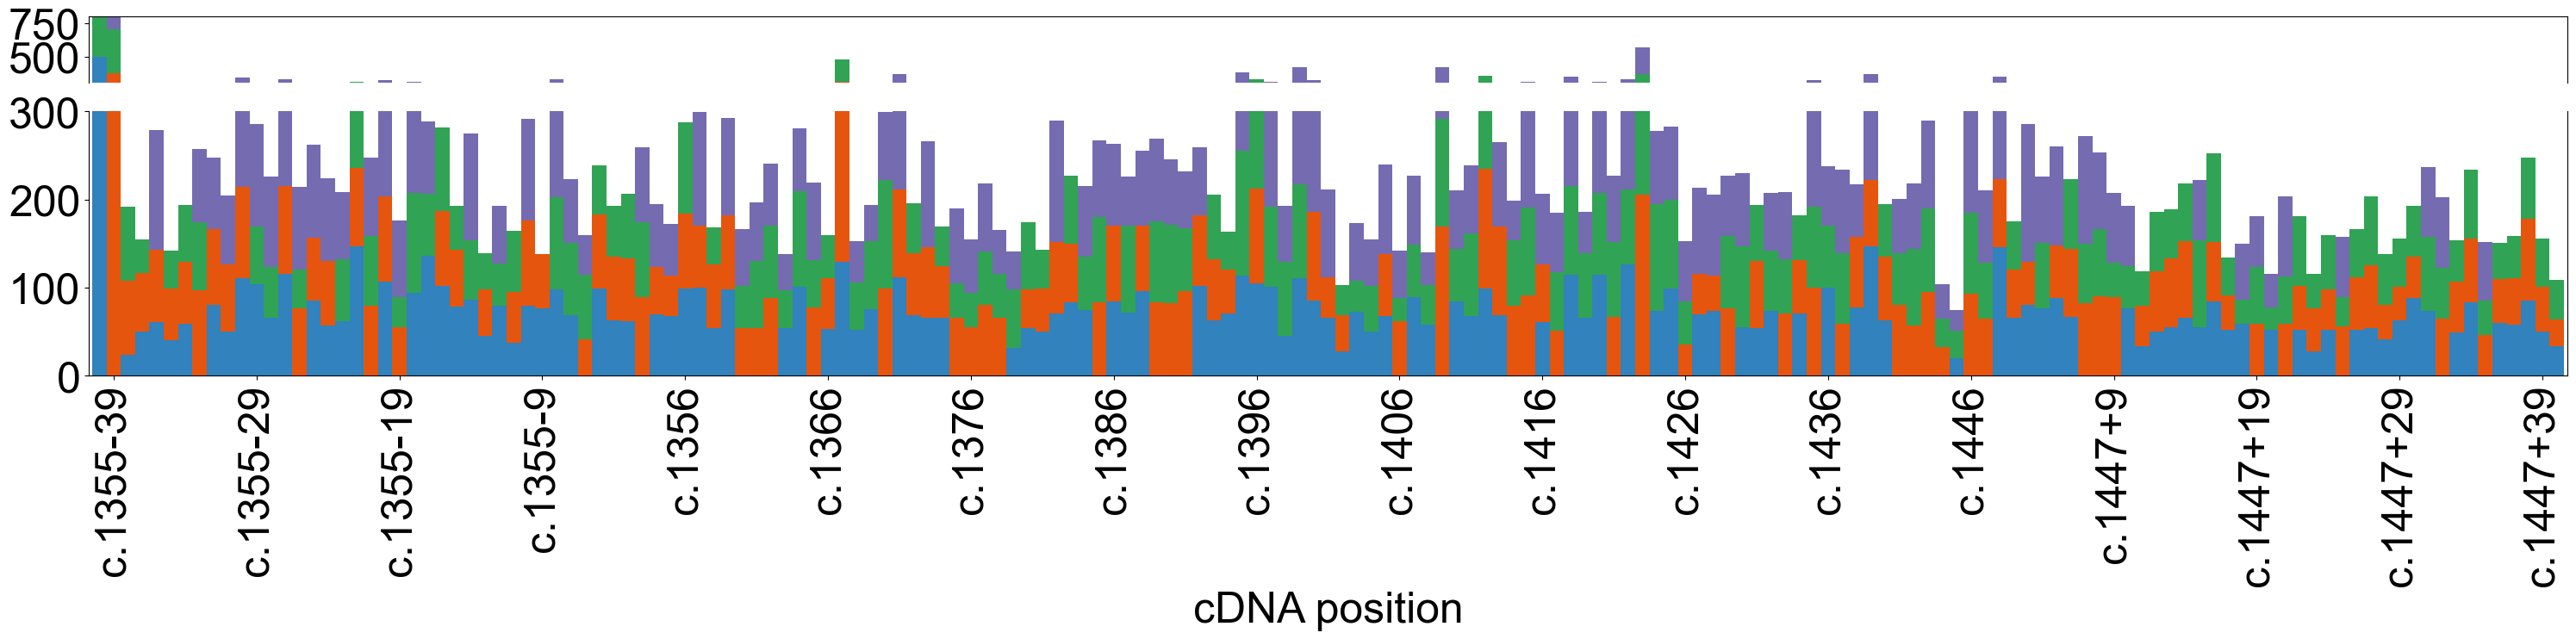

In [65]:
sp.split_ax_bcs(  byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                  [ 'n_bc_passfilt_mean' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 300.5, 800 ), ( 0, 300 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'cDNA position',
                    #tight = False,
                    savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

In [66]:
kts_p_hek = [ col for col in byvartbl_wide if col.endswith( '_wmean_KTS+' ) and 'Hek' in col ]

In [67]:
kts_p_cos = [ col for col in byvartbl_wide if col.endswith( '_wmean_KTS+' ) and 'Cos' in col ]

In [68]:
kts_n_hek = [ col for col in byvartbl_wide if col.endswith( '_wmean_KTS-' ) and 'Hek' in col ]

In [69]:
kts_n_cos = [ col for col in byvartbl_wide if col.endswith( '_wmean_KTS-' ) and 'Cos' in col ]

In [70]:
skip_hek = [ col for col in byvartbl_wide if col.endswith( '_wmean_SKIP' ) and 'Hek' in col ]

In [71]:
skip_cos = [ col for col in byvartbl_wide if col.endswith( '_wmean_SKIP' ) and 'Cos' in col ]

In [72]:
other_hek = [ col for col in byvartbl_wide if col.endswith( '_wmean_OTHER' ) and 'Hek' in col ]

In [73]:
other_cos = [ col for col in byvartbl_wide if col.endswith( '_wmean_OTHER' ) and 'Cos' in col ]

In [74]:
hek_corr = pd.concat( [ byvartbl_wide[ kts_p_hek ].corr( method = 'pearson' ).stack(),
                        byvartbl_wide[ kts_n_hek ].corr( method = 'pearson' ).stack(),
                        byvartbl_wide[ skip_hek ].corr( method = 'pearson' ).stack(),
                        byvartbl_wide[ other_hek ].corr( method = 'pearson' ).stack(),
                        ] ) 

In [75]:
hek_corr.where( hek_corr != 1 ).median()

0.93924908309131

In [76]:
kts_p_btw_corr = byvartbl_wide[ kts_p_hek + kts_p_cos ].corr( method = 'pearson' )[ kts_p_cos ].loc[ kts_p_hek ].stack()

In [77]:
kts_n_btw_corr = byvartbl_wide[ kts_n_hek + kts_n_cos ].corr( method = 'pearson' )[ kts_n_cos ].loc[ kts_n_hek ].stack()

In [78]:
skip_btw_corr = byvartbl_wide[ skip_hek + skip_cos ].corr( method = 'pearson' )[ skip_cos ].loc[ skip_hek ].stack()

In [79]:
other_btw_corr = byvartbl_wide[ other_hek + other_cos ].corr( method = 'pearson' )[ other_cos ].loc[ other_hek ].stack()

In [80]:
btw_corr = pd.concat( [ kts_p_btw_corr, kts_n_btw_corr, skip_btw_corr, other_btw_corr ] )

In [81]:
btw_corr.where( btw_corr != 1 ).median()

0.9283471928051108

In [82]:
sns.set_theme( font_scale = 3 )

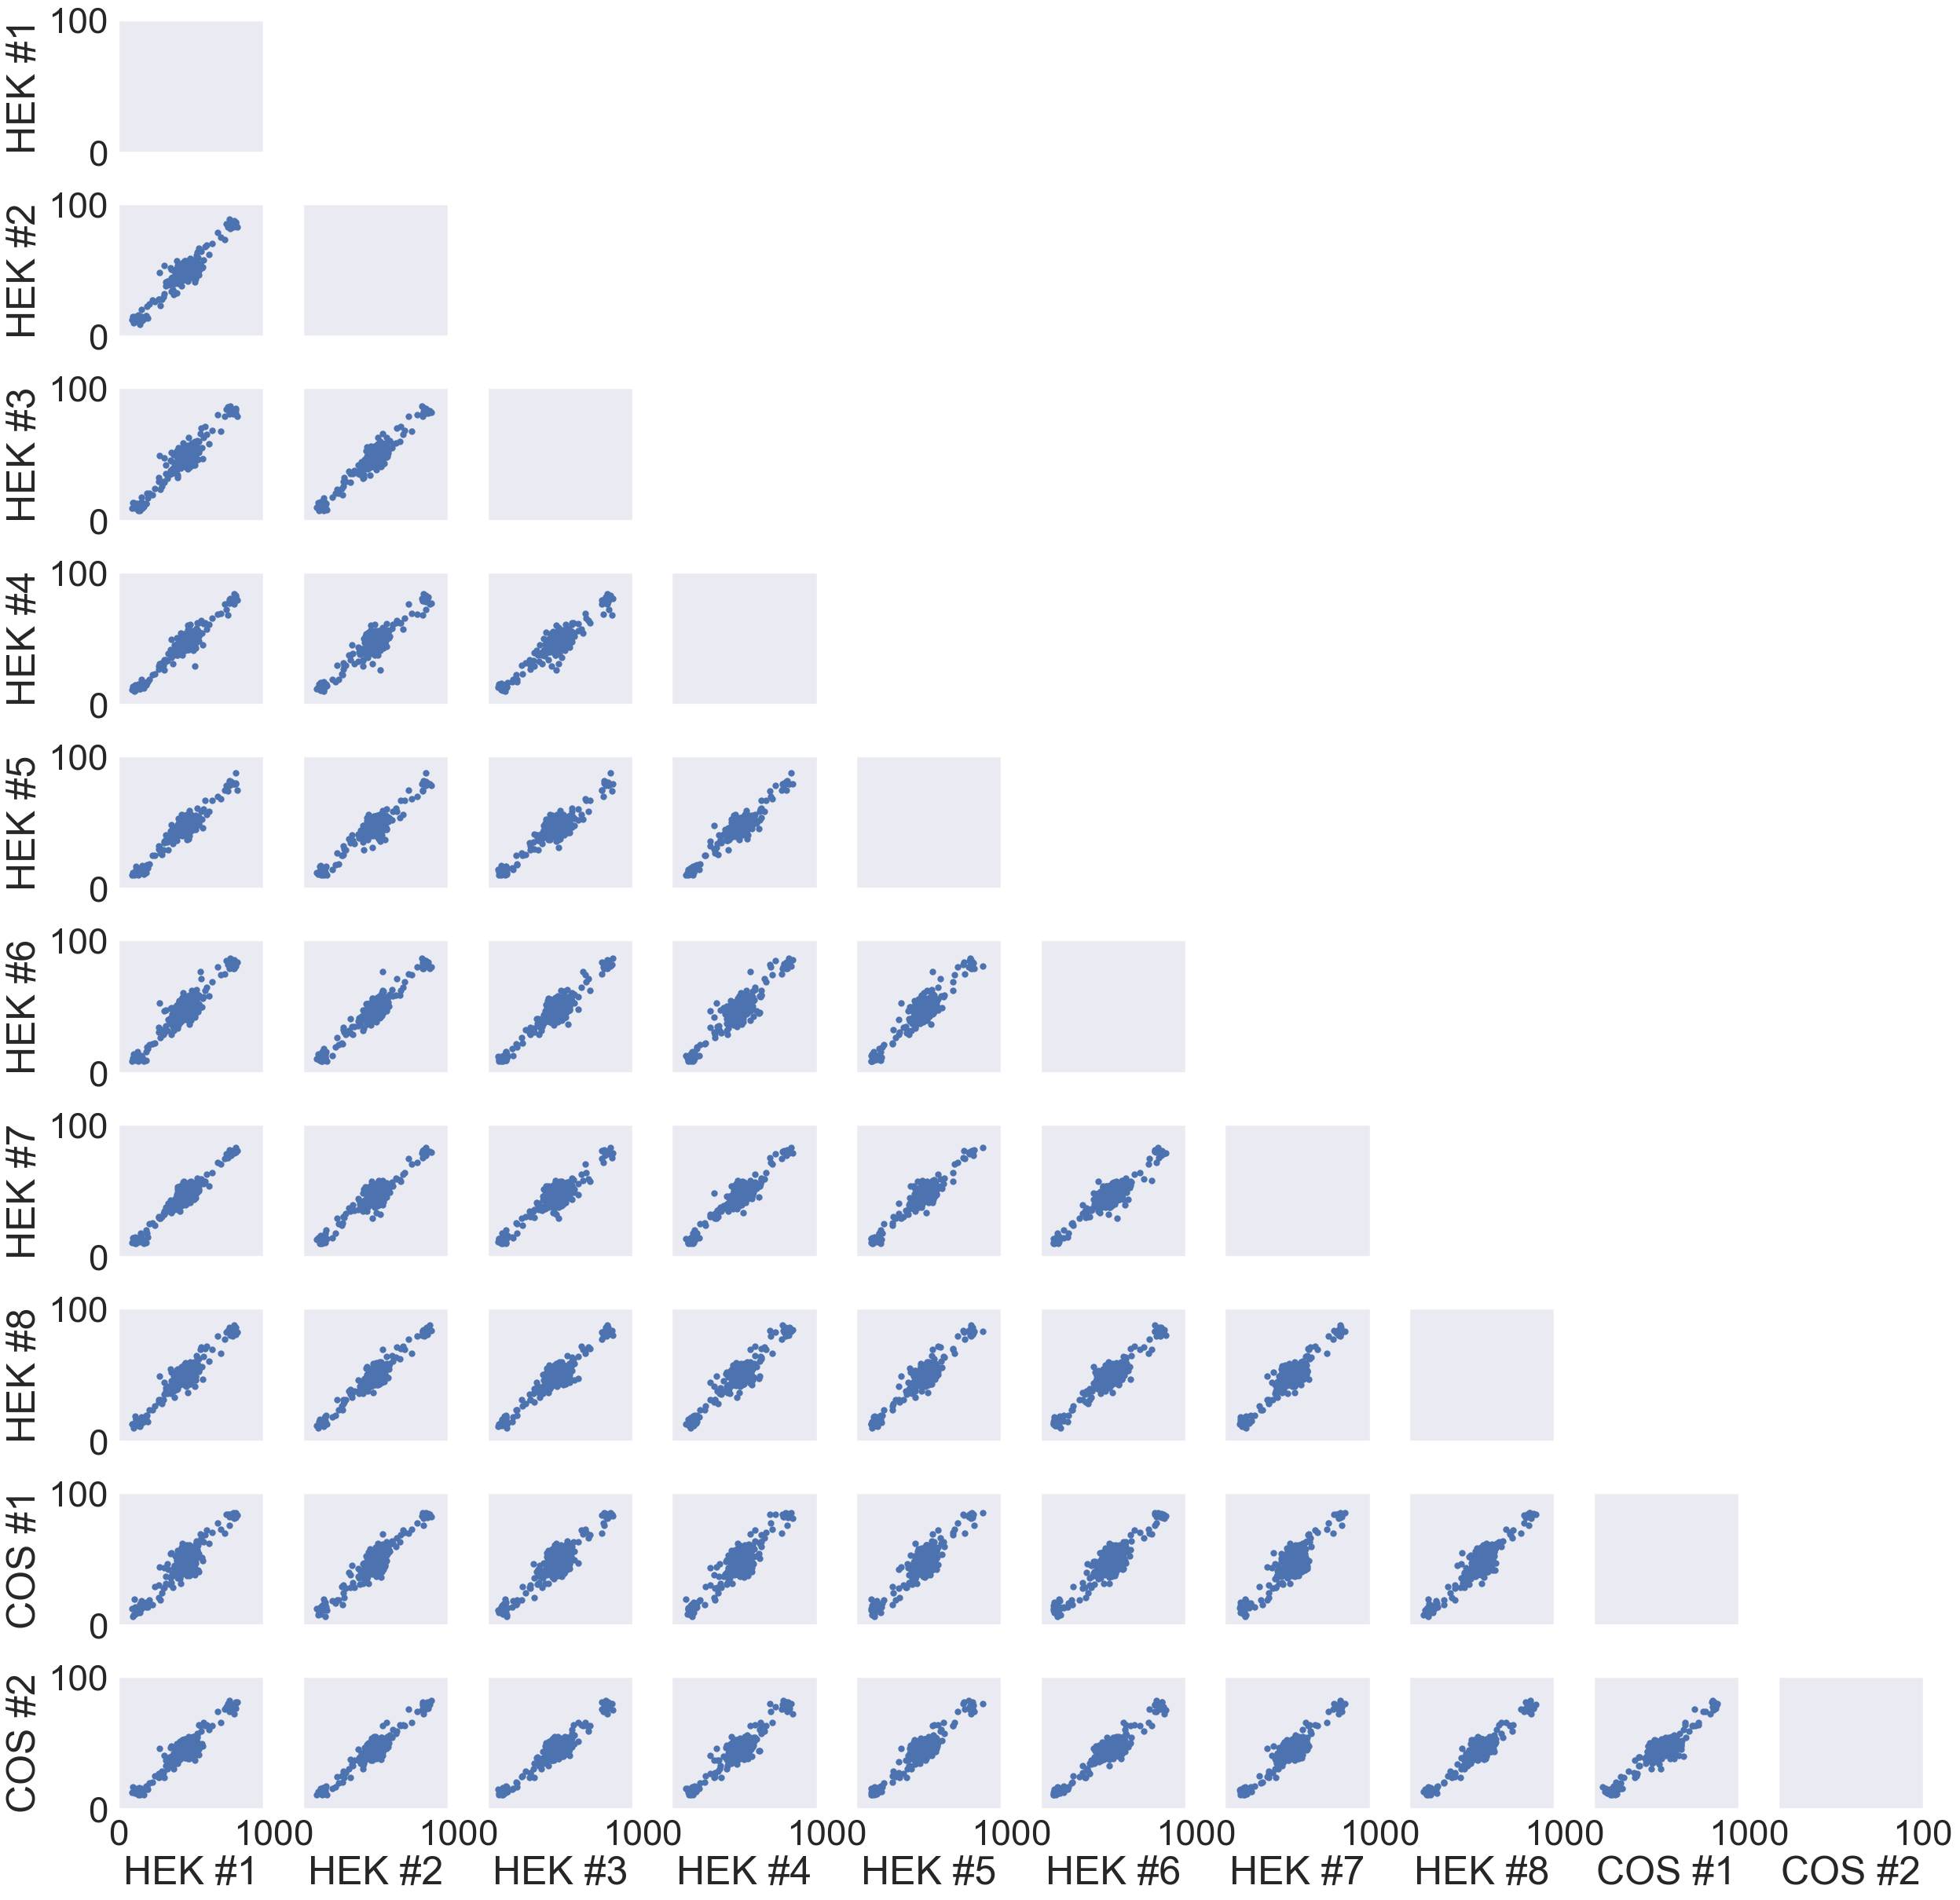

In [83]:
g = sns.PairGrid( byvartbl_wide[ kts_p_hek + kts_p_cos ].apply( lambda x: x*100 ),
                    corner = True,
                  palette = light_colors
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 100 ), 
         xlim = ( 0, 100 ),
       )
labels = [ 'HEK #' + str( i + 1 ) for i in range( len( kts_p_hek ) ) ] + [ 'COS #' + str( i + 1 ) for i in range( len( kts_p_cos ) ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )
        
g.savefig( plot_out + 'KTS+_corr.pdf' )    

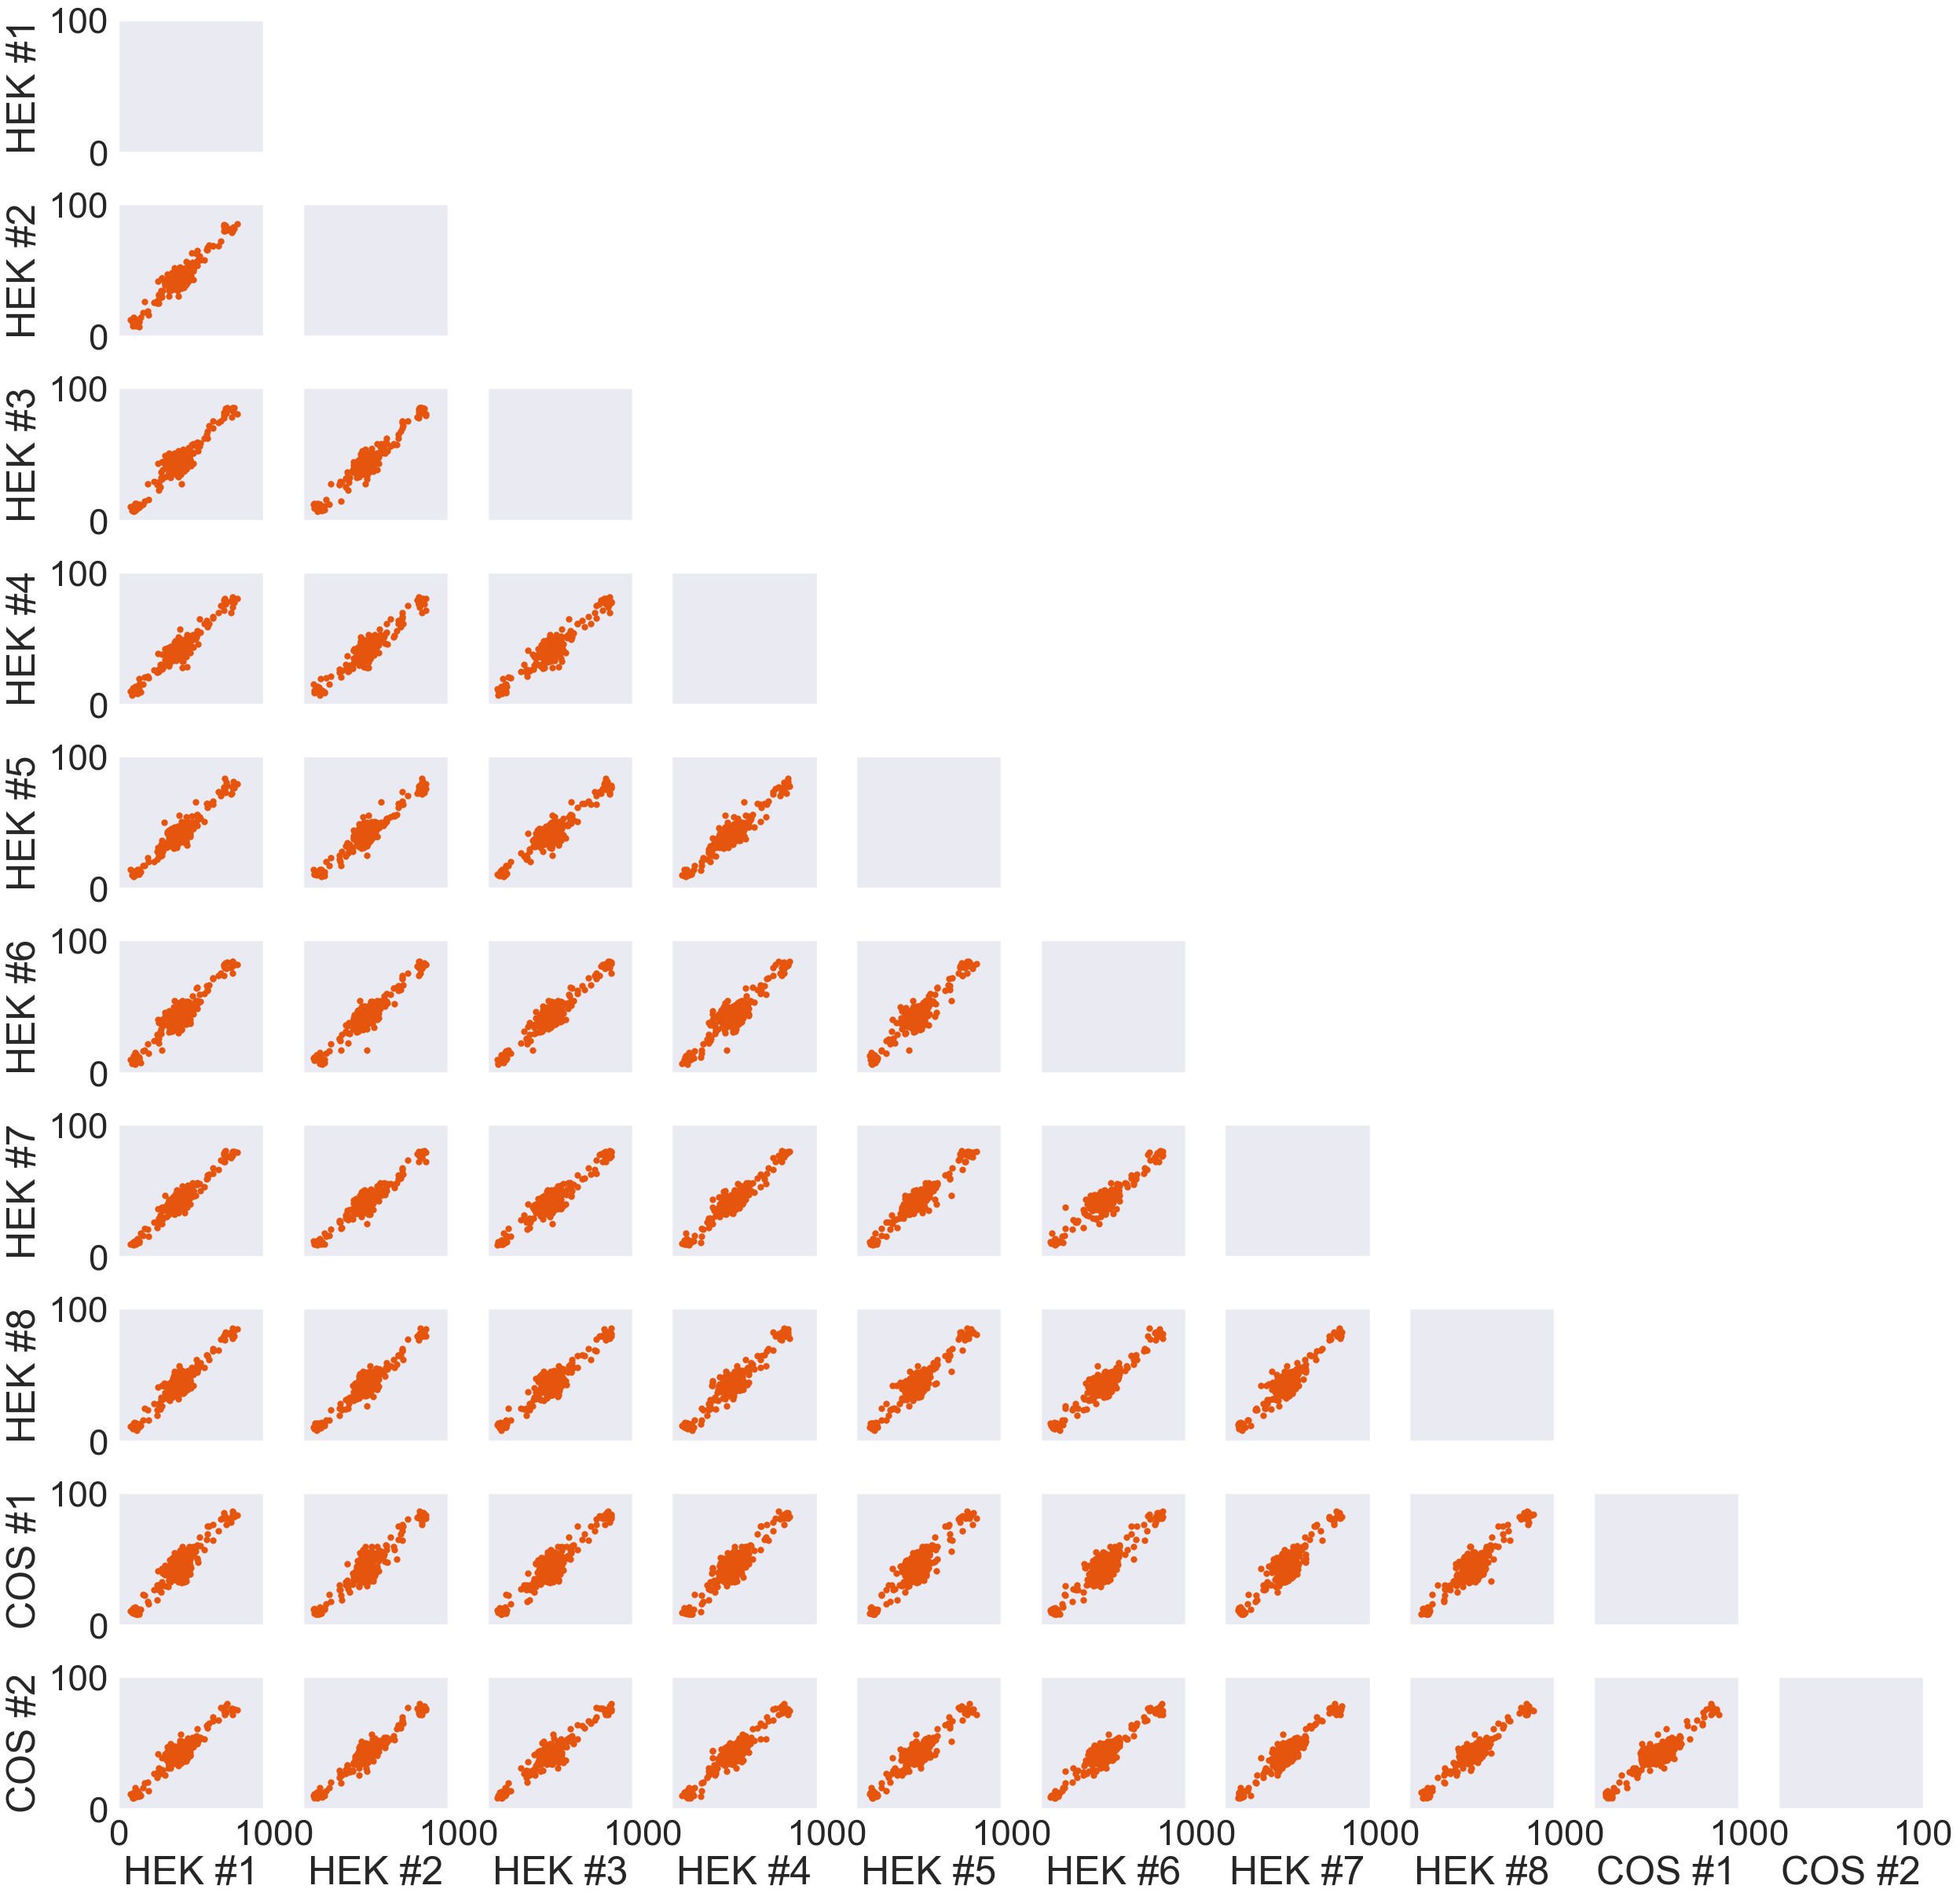

In [84]:
sns.set_palette( palette = light_colors[4:] )
g = sns.PairGrid( byvartbl_wide[ kts_n_hek + kts_n_cos ].apply( lambda x: x*100 ),
                    corner = True,
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 100 ), 
         xlim = ( 0, 100 ),
       )
labels = [ 'HEK #' + str( i + 1 ) for i in range( len( kts_n_hek ) ) ] + [ 'COS #' + str( i + 1 ) for i in range( len( kts_n_cos ) ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )
        
g.savefig( plot_out + 'KTS-_corr.pdf' )    

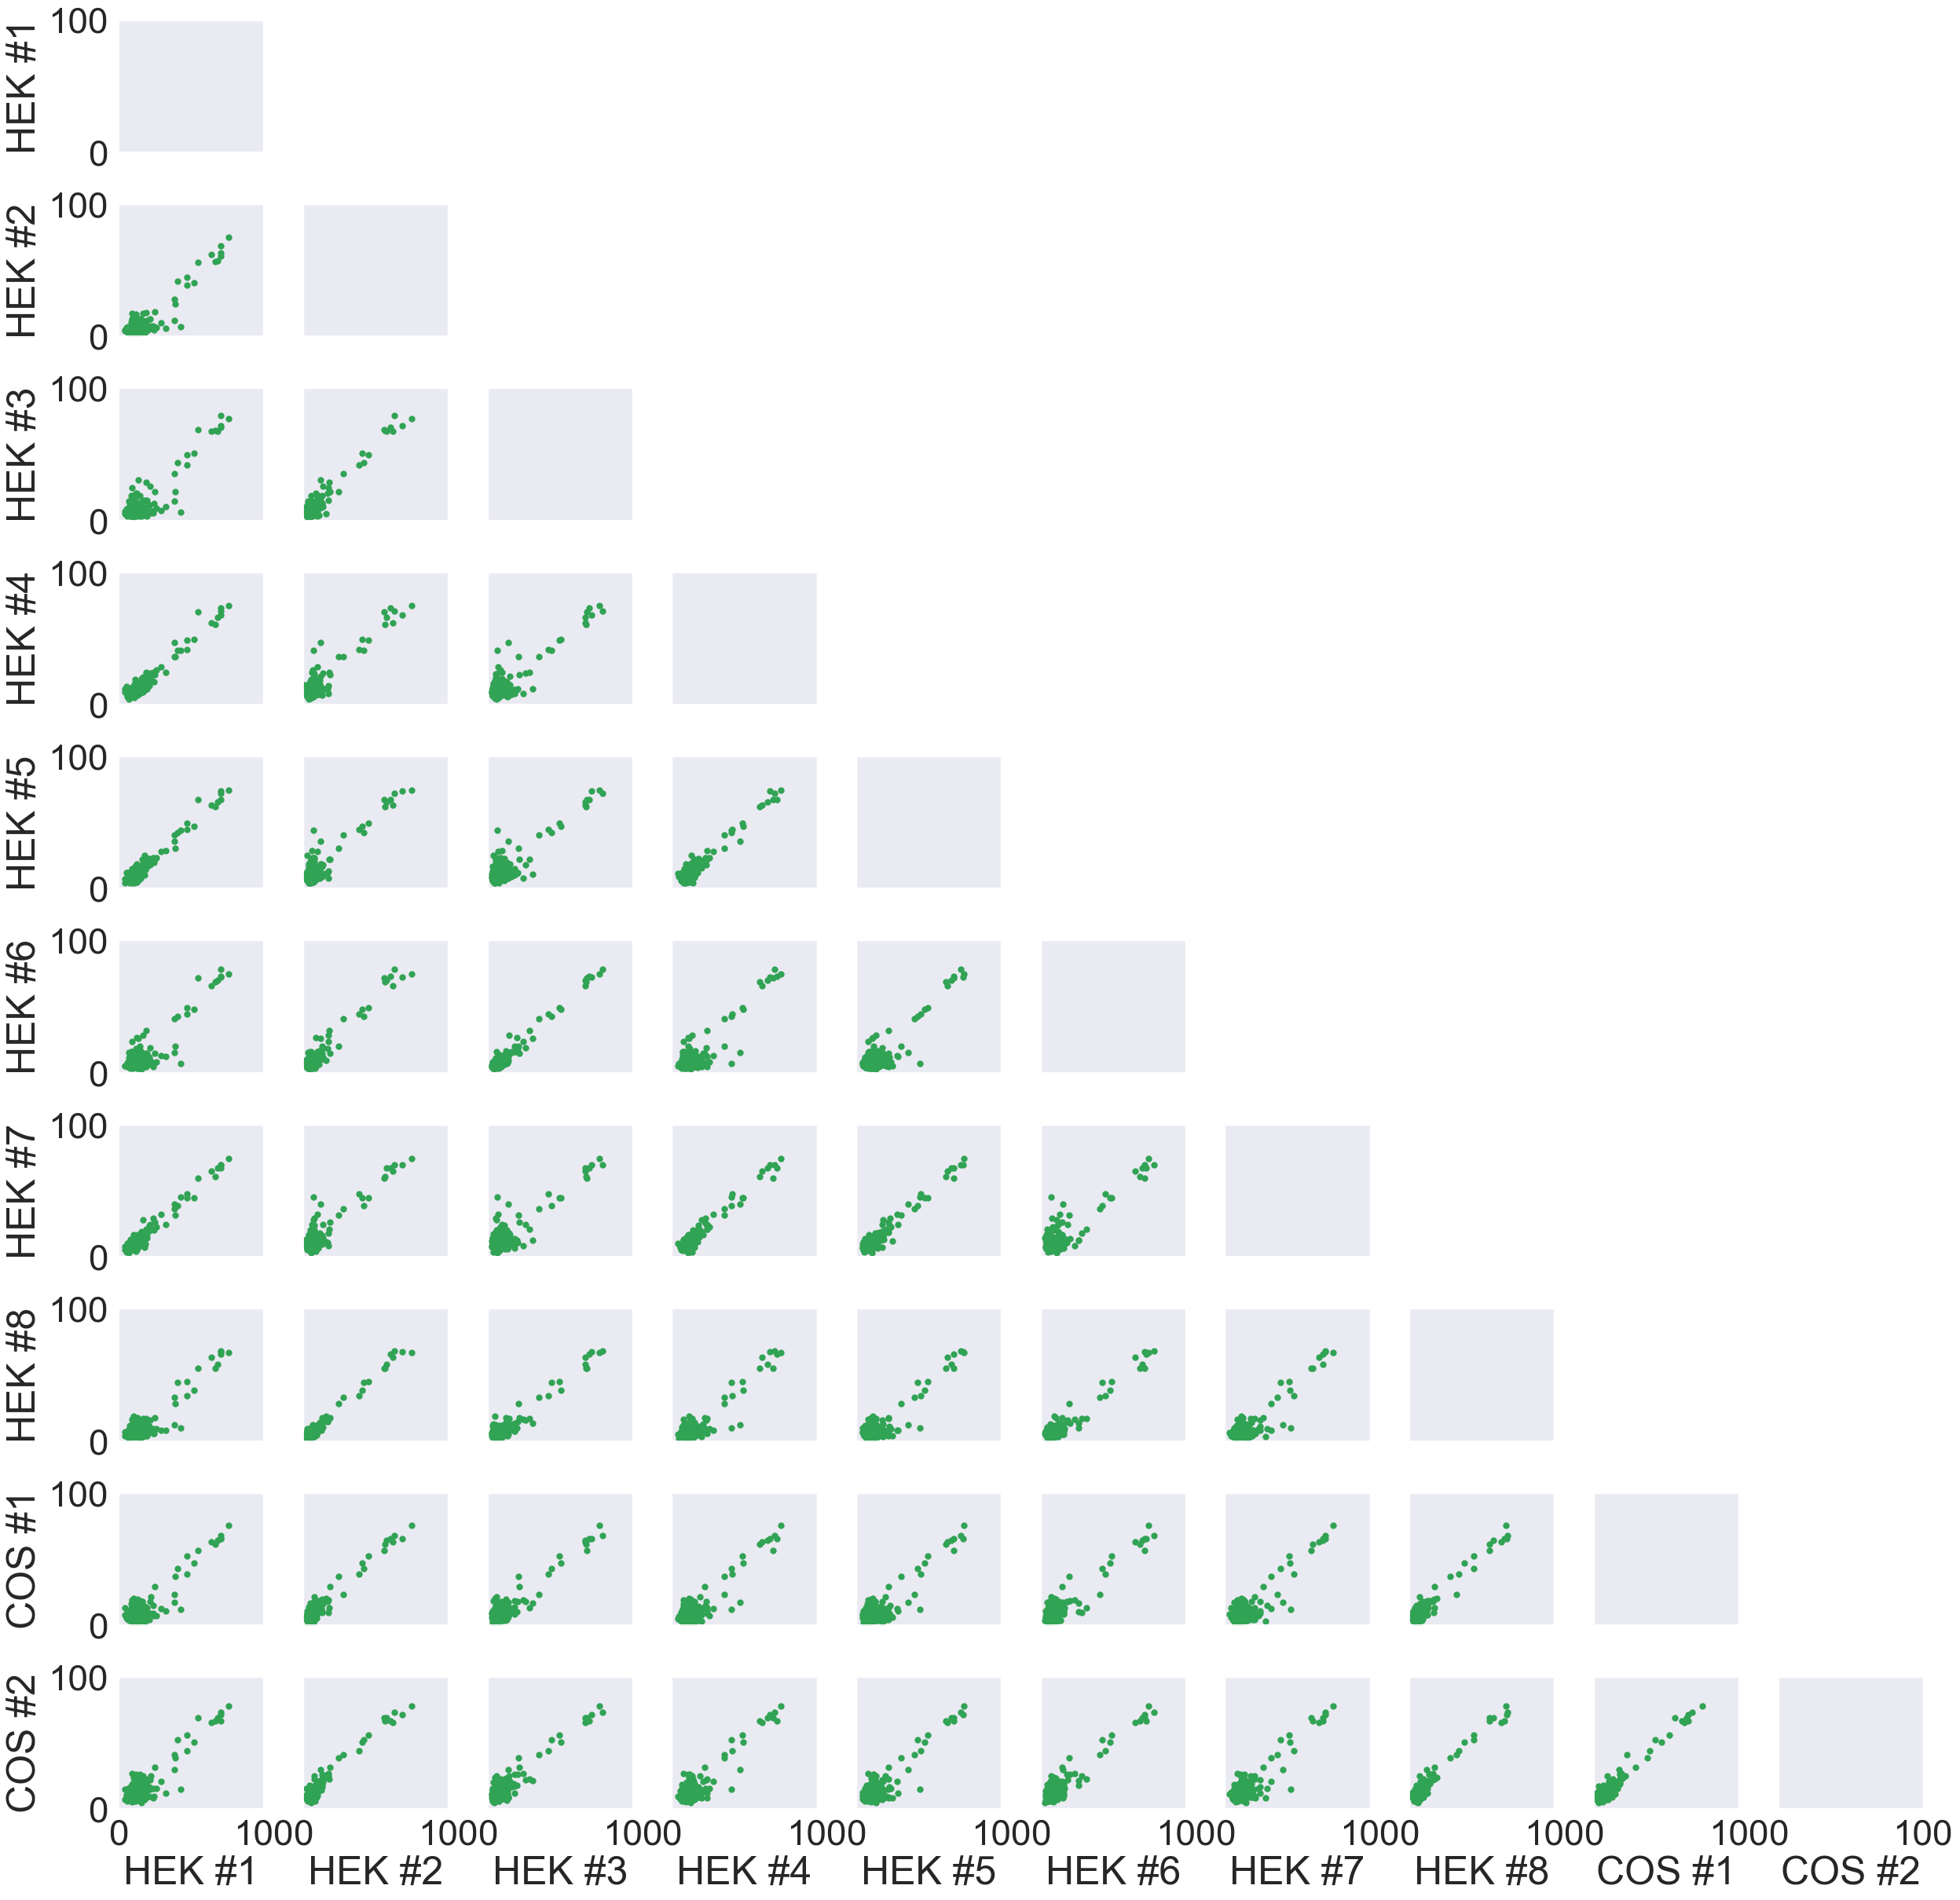

In [85]:
sns.set_palette( palette = light_colors[8:] )
g = sns.PairGrid( byvartbl_wide[ skip_hek + skip_cos ].apply( lambda x: x*100 ),
                    corner = True,
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 100 ), 
         xlim = ( 0, 100 ),
       )
labels = [ 'HEK #' + str( i + 1 ) for i in range( len( skip_hek ) ) ] + [ 'COS #' + str( i + 1 ) for i in range( len( skip_cos ) ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )
        
g.savefig( plot_out + 'SKIP_corr.pdf' )    

In [86]:
byvartbl_wide[ other_hek + other_cos ].max().max()

0.3980582524271844

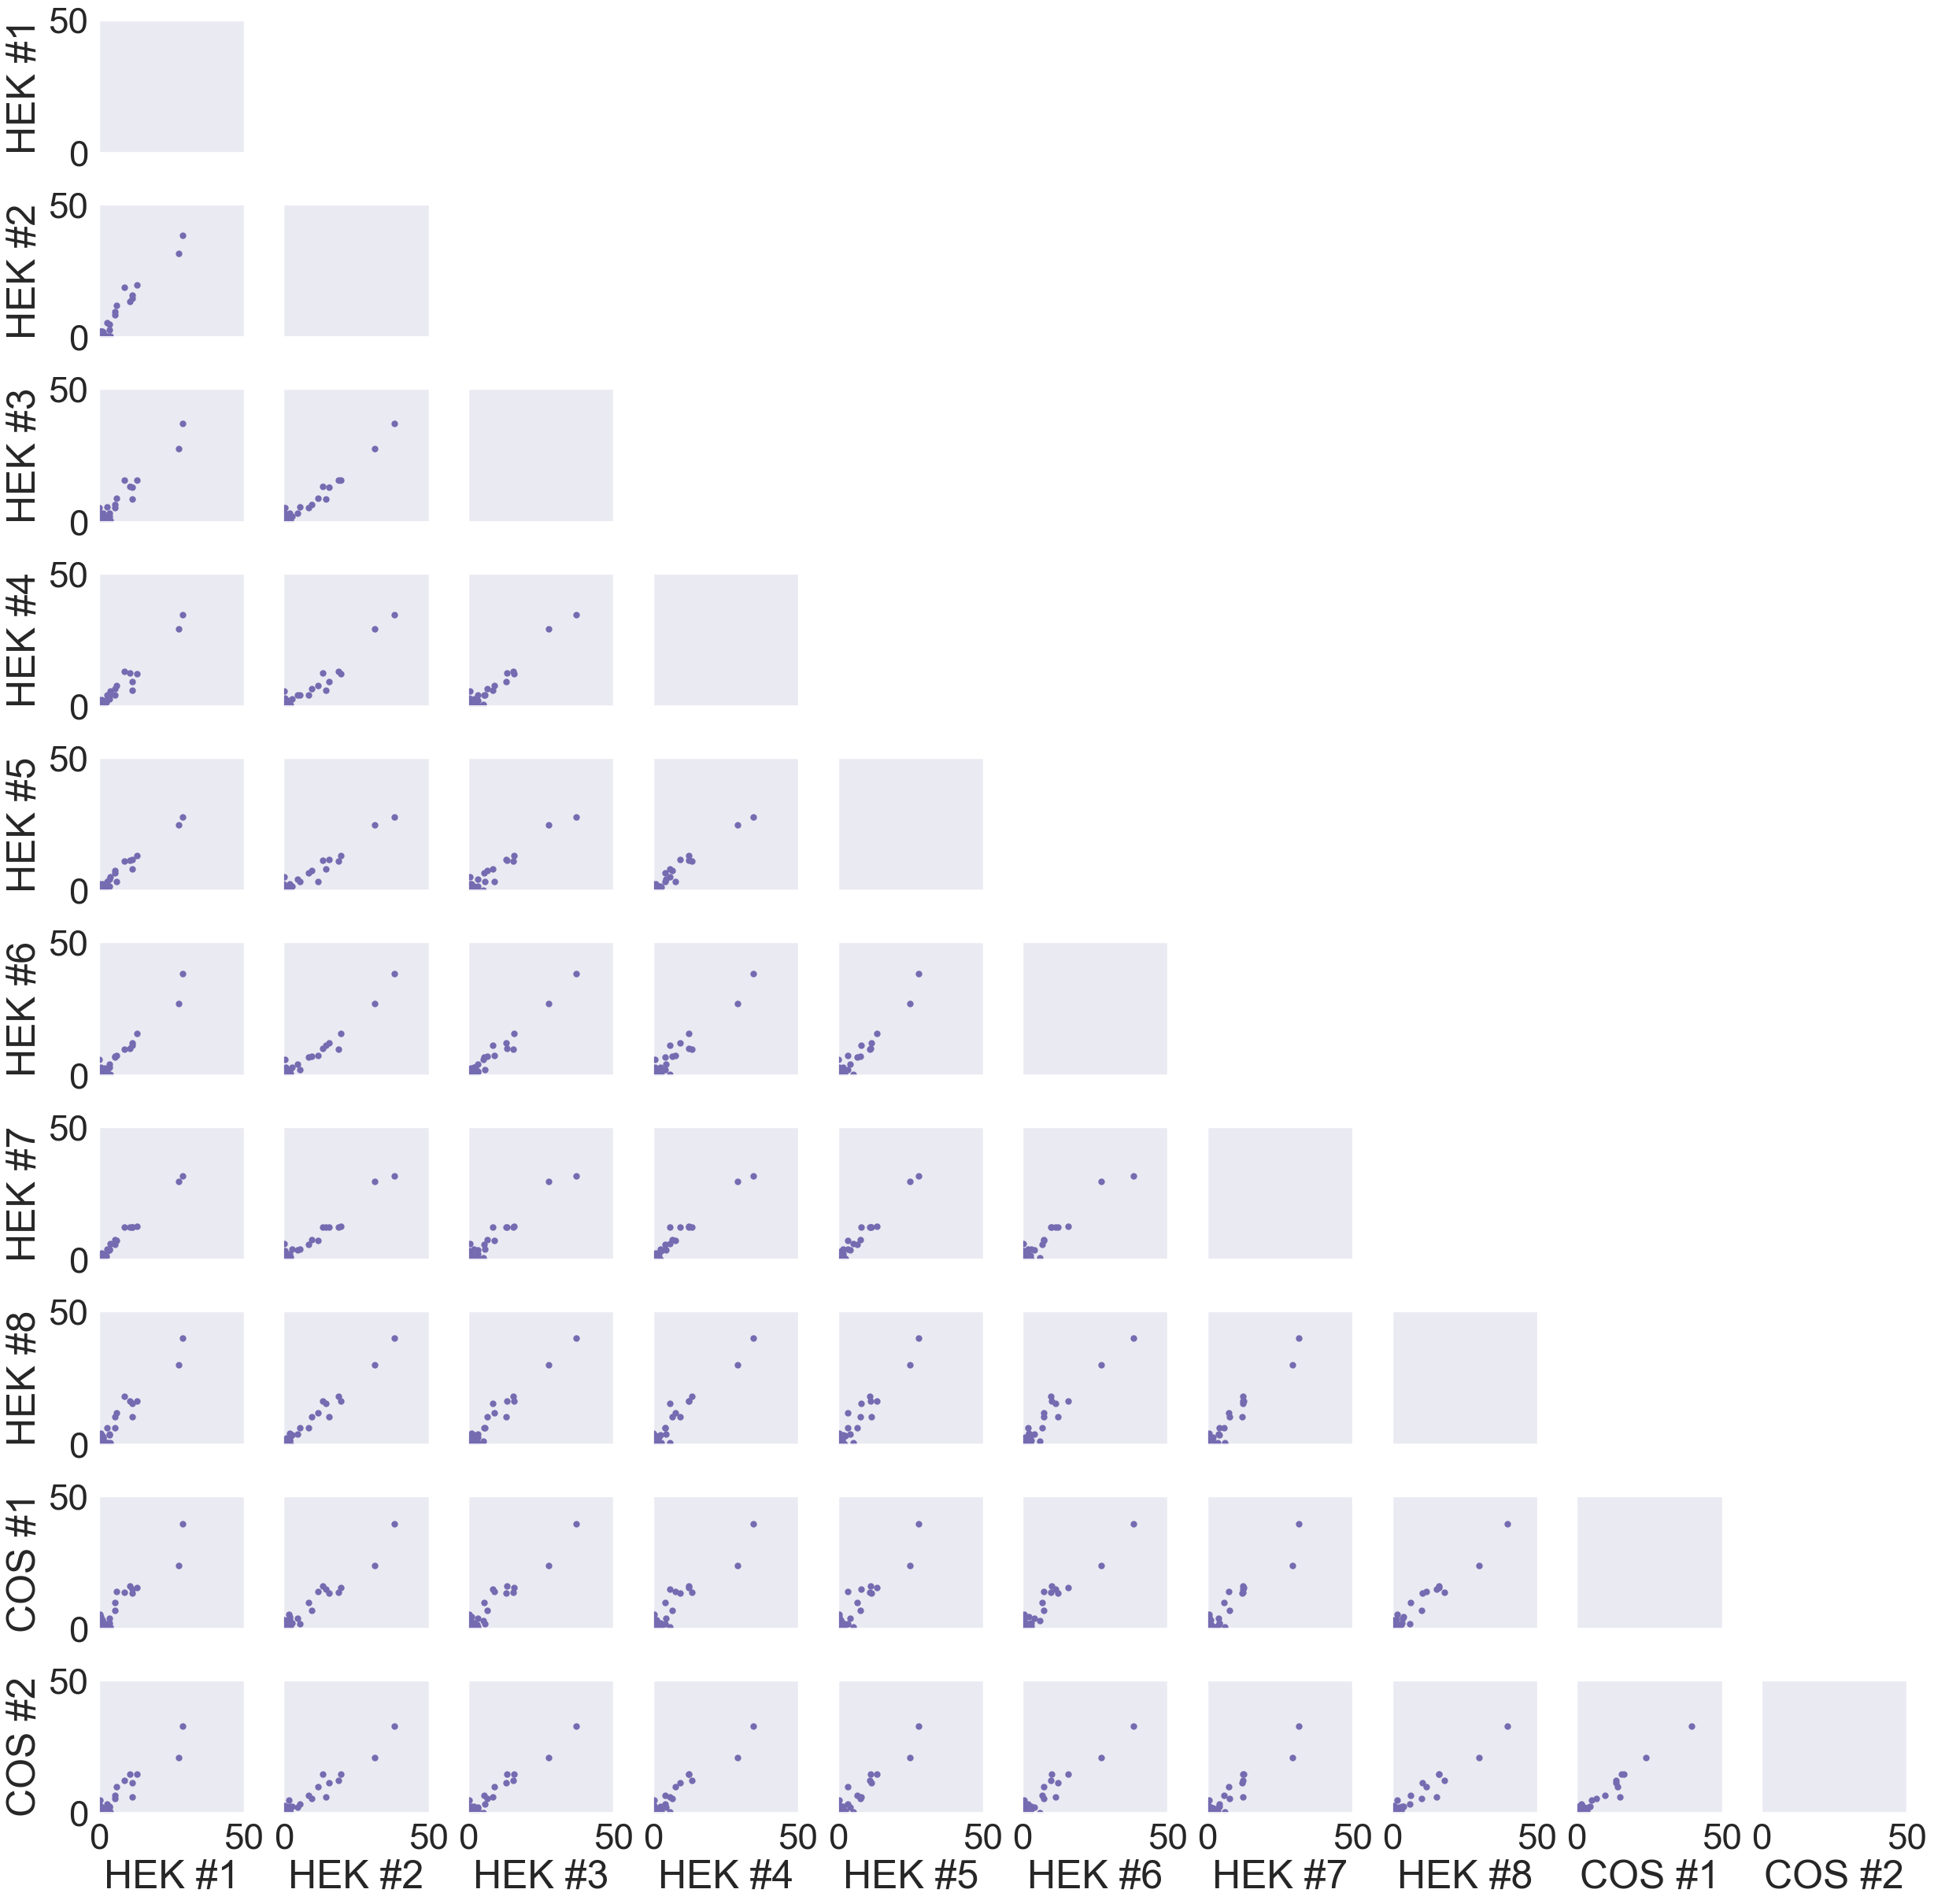

In [87]:
sns.set_palette( palette = light_colors[12:] )
g = sns.PairGrid( byvartbl_wide[ other_hek + other_cos ].apply( lambda x: x*100 ),
                    corner = True,
                  )
#g.map_diag( sns.histplot, binwidth = 2 )
g.map_offdiag( sns.scatterplot, rasterized = True, linewidth = 0 )
g.set( ylim = ( 0, 50 ), 
         xlim = ( 0, 50 ),
       )
labels = [ 'HEK #' + str( i + 1 ) for i in range( len( other_hek ) ) ] + [ 'COS #' + str( i + 1 ) for i in range( len( other_cos ) ) ]

for i, ax in enumerate( g.axes.flat ):
    if i % len( labels ) == 0:
        ax.set_ylabel( labels[ int( i / len( labels ) ) ] )
    if i >= ( len( labels )*( len( labels ) - 1 )  ):
        ax.set_xlabel( labels[ int( i - ( len( labels )*( len( labels ) - 1 )  ) ) ] )
        
g.savefig( plot_out + 'OTHER_corr.pdf' )    

In [88]:
byvartbl_wide.sdv.sum()

57

In [89]:
byvartbl_wide.sdv.sum() / len( byvartbl_wide )

0.11003861003861004

In [90]:
byvartbl_wide.intmed.sum()

16

In [91]:
byvartbl_wide.intmed.sum() / len( byvartbl_wide )

0.03088803088803089

In [92]:
byvartbl_wide[ 'dist_to_ss' ] = [ min( abs( p - ss ) for ss in [ 1267, 1359 ] ) for p in byvartbl_wide.pos  ]

In [93]:
( byvartbl_wide.loc[ byvartbl_wide.sdv ].dist_to_ss < 15 ).sum()

56

In [94]:
byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ].sum()

43

In [95]:
byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ].sum() / byvartbl_wide.sdv.sum()

0.7543859649122807

In [96]:
( ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] < 0 ) ).sum()

24

In [97]:
( ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) ).sum()

19

In [98]:
byvartbl_wide.sdv_SKIP.sum()

14

In [99]:
byvartbl_wide.sdv_OTHER.sum()

2

In [100]:
codon_dict = {
    "GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D",
    "GAA": "E", "GAG": "E",
    "TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "CAT": "H", "CAC": "H",
    "ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K",
    "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M",
    "AAT": "N", "AAC": "N",
    "CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R",
    "TCT": "S", "TCC": "S", "TCA": "S", "TCG": "S", "AGT": "S", "AGC": "S",
    "ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V",
    "TGG": "W",
    "TAT": "Y", "TAC": "Y",
    "TAA": "_", "TAG": "_", "TGA": "_"
}

In [101]:
#the G comes from exon 8 which has one bp as part of the frame
alt_acc_seq = 'G' + refseq[ 1283:1359 ]

In [102]:
#this is the amino acid sequence for exon 9 for the alternate acceptor sequence...no PTC
#don't go into exon 10 because that's the final exon
#PTC codon right away > 50 bp from final exon junction
''.join( [ codon_dict[ alt_acc_seq[ codon_pos: codon_pos + 3 ] ] \
           for codon_pos in range( 0, len( alt_acc_seq ), 3 ) \
           if ( codon_pos + 3 ) < len( alt_acc_seq ) ] )

'V_NLSAKVLPVRPPEDPHQDSYR_N'

In [103]:
( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ).sum()

8

In [104]:
byvartbl_wide.loc[ ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ][ 'wmean_KTS_+_ratio_log2' ].max()

-2.209921242805474

In [105]:
byvartbl_wide.loc[ byvartbl_wide.lit_interp.isnull(), 'lit_interp' ] = ''

In [106]:
byvartbl_wide.lit_interp.unique()

array(['', 'Benign/Likely_benign (CV/ACMG)',
       'Pathogenic/Likely_pathogenic (CV)',
       'Pathogenic/Likely_pathogenic (ACMG)', 'VUS/Conflicting (CV)'],
      dtype=object)

In [107]:
lit_marker_d = { 'Benign/Likely_benign (CV/ACMG)': ( 's', 'white', 'black', 3, 400 ),
                 'Pathogenic/Likely_pathogenic (CV)': ( '^', 'black', 'face', 1.5, 400 ),
                 'Pathogenic/Likely_pathogenic (ACMG)': ( 'v', 'black', 'face', 1.5, 400 ),
                 'VUS/Conflicting (CV)': ( 'd', 'black', 'face', 1.5, 400 ) }

In [108]:
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

Your labels might not show up in the notebook! Check saved pdf before butchering code!


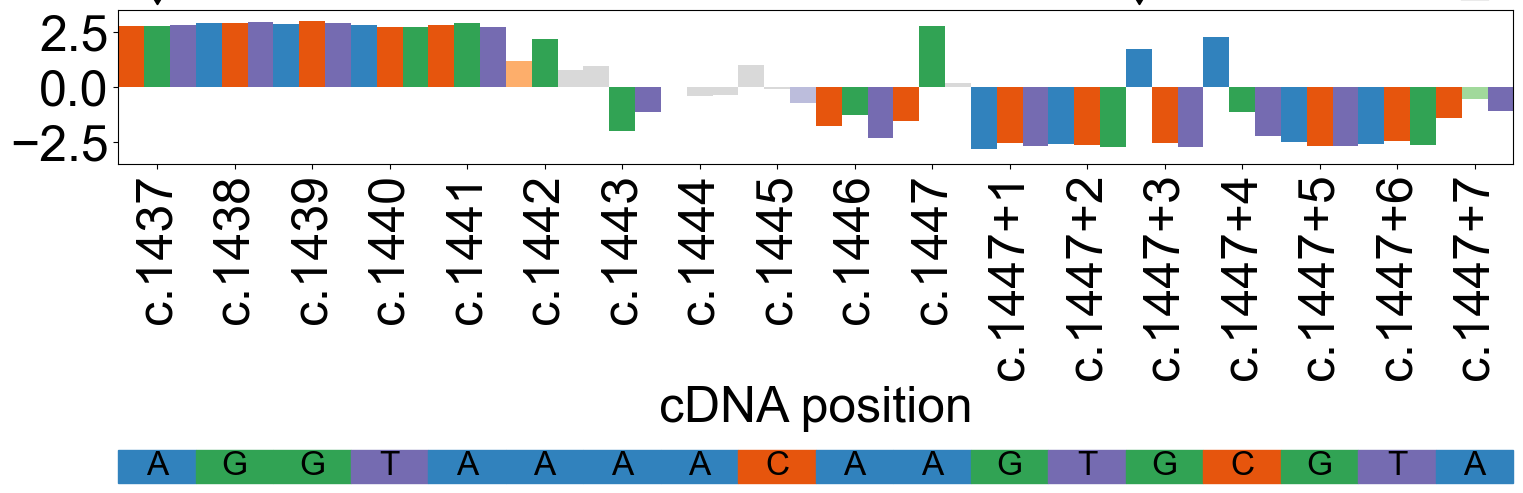

In [110]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ 'wmean_KTS_+_ratio_log2' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1349, 1366 ),
                          fig_size = ( 18, 2 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( -3.5, 3.5 ) ],
                          y_ax_title = [ '' ], 
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -18,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          ref_font_size = 24,
                          ref_rect_ht = 1.5,
                          bar_labels = [ ( 'lit_interp', lit_marker_d, 4.7 ) ],
                          tight = False,
                          save_margin = 1,
                          savefile = plot_out + 'KTS_ratio_zoom.pdf'
                     )

In [111]:
def plot_clinvar_by_interp( tbl_by_var,
                            yaxis_cols,
                            marker_d,
                            interp_col = 'lit_interp',
                            sort_col = 'pos',
                            plot_pos_col = 'hgvs_var',
                            figsize = ( 8, 3 ),
                            sharex = 'col',
                            sharey = 'row',
                            col_label = None,
                            row_label = None,
                            ylim = None,
                            gnomad_labels = None,
                            savefig = False,
                            ):
    
    tbv = tbl_by_var.loc[ tbl_by_var[ interp_col ] != '' ].copy()
    
    fig,ax = plt.subplots( len( yaxis_cols ), len( tbv[ interp_col ].unique() ),
                           gridspec_kw = { 'width_ratios' : [ len( tbv.loc[ tbv[ interp_col ] == l ] ) for l in tbv[ interp_col ].unique() ] },
                           sharex = sharex,
                           sharey = sharey,
                           figsize = figsize,
                           squeeze = False )
    
    for i,interp in enumerate( tbv[ interp_col ].unique() ):
    
        interp_df = tbv.loc[ tbv[ interp_col ] == interp ].sort_values( by = sort_col ).reset_index().copy()
        
        marker, color, edgecolor, linewidth, size = marker_d[ interp ]
        
        if col_label:

            ax[ 0 ][ i ].set_title( interp.replace( '(', '\n(' ),
                                    fontsize = 14 )
    
        for j,ycol in enumerate( yaxis_cols ):
    
            ax[ j ][ i ].scatter( interp_df.index,
                                  interp_df[ ycol ],
                                  marker = marker,
                                  color = color,
                                  edgecolor = edgecolor,
                                  linewidth = linewidth,
                                  s = size )
        
            if row_label:

                ax[ j ][ 0 ].set_ylabel( ycol )
    
            #my stupid markers keep getting cut off
            x_l,x_r = ax[ j ][ i ].get_xlim()
    
            ax[ j ][ i ].set_xlim( ( x_l - .5, x_r + .5 ) )
    
        ax[ j ][ i ].set_xticks(  interp_df.index )
    
        ax[ j ][ i ].set_xticklabels( interp_df[ plot_pos_col ],
                                      fontsize=12,
                                      rotation='vertical' )
        
        if ylim:
            
            ax[ j ][ i ].set_ylim( ylim )
        
        if gnomad_labels:
                
            x_coords = ax[ j ][ i ].get_xticks()
                
            for label_col, gnomad_markers, y_coords, in gnomad_labels:

                marker, color, size = gnomad_markers

                ax[ j ][ i ].scatter( x_coords,
                                      [ y_coords if ~np.isnan( label ) else np.nan for label in interp_df[ label_col ] ],
                                      marker = marker,
                                      color = color,
                                      s = size,
                                      clip_on = False )
                        
                for k, val in enumerate( interp_df[ label_col ] ):
                            
                    if np.isnan( val ):
                        continue
                        
                    ax[ j ][ i ].annotate( '%.1E' % val, 
                                           ( x_coords[ k ], y_coords ),
                                           annotation_clip = False,
                                           fontsize = 8,
                                           ha = 'center',
                                           va = 'center',
                                           rotation = 45 )
                    
    if savefig:
        
        plt.savefig( savefig )

    plt.show()

In [112]:
lit_marker_d_color = { 'Benign/Likely_benign (CV/ACMG)': ( 's', dark( 0 ), 'face', 1.5, 100 ),
                       'Pathogenic/Likely_pathogenic (CV)': ( '^', dark( 1 ), 'face', 1.5, 100 ),
                       'Pathogenic/Likely_pathogenic (ACMG)': ( 'v', dark( 2 ), 'face', 1.5, 100 ),
                       'VUS/Conflicting (CV)': ( 'd', dark( 3 ), 'face', 1.5, 100 ) }

In [113]:
byvartbl_wide[ 'gnomad_af_max' ] = byvartbl_wide[ [ 'af_v2', 'af_v3' ] ].max( axis = 1 )

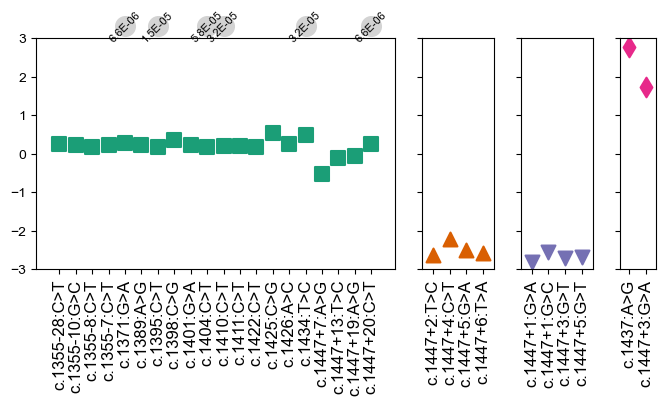

In [114]:
plot_clinvar_by_interp( byvartbl_wide.loc[ ( byvartbl_wide.lit_interp != '' ) & ( byvartbl_wide.var_consequence != 'missense' ) & ( byvartbl_wide.var_consequence != 'stop_gain' )  ],
                        [ 'wmean_KTS_+_ratio_log2', ],
                        lit_marker_d_color,
                        #col_label = lit_marker_d.values(),
                        ylim = ( -3, 3 ),
                        gnomad_labels = [ ( 'gnomad_af_max', 
                                            ( 'o', 'lightgray', 200 ),
                                            3.3 ) ],
                       savefig = plot_out + 'clinvar_interp_gnomad_color.pdf'
                       
                            )

In [115]:
lit_marker_d_smol = { 'Benign/Likely_benign (CV/ACMG)': ( 's', 'white', 'black', 3, 100 ),
                       'Pathogenic/Likely_pathogenic (CV)': ( '^', 'black', 'face', 1.5, 100 ),
                       'Pathogenic/Likely_pathogenic (ACMG)': ( 'v', 'black', 'face', 1.5, 100 ),
                       'VUS/Conflicting (CV)': ( 'd', 'black', 'face', 1.5, 100 ) }

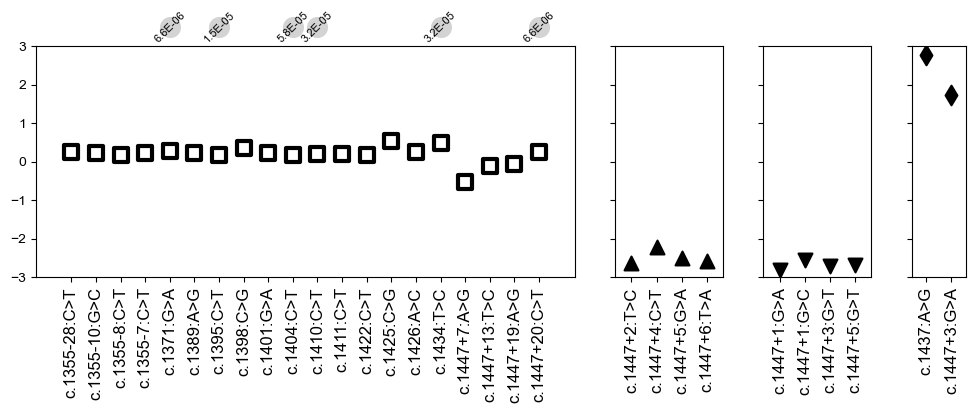

In [116]:
plot_clinvar_by_interp( byvartbl_wide.loc[ ( byvartbl_wide.lit_interp != '' ) & ( byvartbl_wide.var_consequence != 'missense' ) & ( byvartbl_wide.var_consequence != 'stop_gain' )  ],
                        [ 'wmean_KTS_+_ratio_log2', ],
                        lit_marker_d_smol,
                        figsize = ( 12, 3 ),
                        #col_label = lit_marker_d.values(),
                        ylim = ( -3, 3 ),
                        gnomad_labels = [ ( 'gnomad_af_max', 
                                            ( 'o', 'lightgray', 200 ),
                                            3.5 ) ],
                       savefig = plot_out + 'clinvar_interp_gnomad_bw.pdf'
                       
                            )

In [117]:
#we don't have any benign variants in clinvar
( byvartbl_wide.clinvar_interp == 'Likely_benign' ).sum()

19

In [118]:
byvartbl_wide.loc[ byvartbl_wide.clinvar_interp == 'Likely_benign' ].sdv.sum()

0

In [119]:
byvartbl_wide.loc[ byvartbl_wide.clinvar_interp == 'Likely_benign' ].intmed.sum()

1

In [120]:
( ( byvartbl_wide.gnomad ) & ~( byvartbl_wide.clinvar_interp == 'Likely_benign' ) ).sum()

17

In [121]:
( ( byvartbl_wide.gnomad ) & ( byvartbl_wide.sdv ) ).sum()

0

In [122]:
( ( byvartbl_wide.gnomad ) & ( byvartbl_wide.intmed ) ).sum()

0

In [123]:
byvartbl_wide.loc[ ( ( byvartbl_wide.gnomad ) | ( byvartbl_wide.clinvar_interp == 'Likely_benign' ) ) & ~ ( byvartbl_wide.intmed ) ][ 'wmean_KTS_+_ratio_log2' ].min()

-0.1088590575978839

In [124]:
byvartbl_wide.loc[ ( ( byvartbl_wide.gnomad ) | ( byvartbl_wide.clinvar_interp == 'Likely_benign' ) ) & ~ ( byvartbl_wide.intmed ) ][ 'wmean_KTS_+_ratio_log2' ].max()

0.5301618508611649

In [125]:
byvartbl_wide.loc[ ( byvartbl_wide.clinvar_interp == 'Likely_benign' ) & ( byvartbl_wide.intmed ) ].hgvs_var

100    c.1447+7:A>G
Name: hgvs_var, dtype: object

In [126]:
byvartbl_wide.loc[ ( byvartbl_wide.clinvar_interp == 'Likely_benign' ) & ( byvartbl_wide.intmed ) ][ 'wmean_KTS_+_ratio_log2' ]

100   -0.523512
Name: wmean_KTS_+_ratio_log2, dtype: float64

In [127]:
( ~( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] < 0 ) ).sum()

16

In [128]:
byvartbl_wide.loc[ ~( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] < 0 ) ][ 'wmean_KTS_+_ratio_log2' ].median()

-2.14152753217854

In [129]:
( ~( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] < 0 ) & ( byvartbl_wide.pos > 1350 ) & ( byvartbl_wide.pos <= 1359 ) ).sum()

6

In [130]:
( ~( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] < 0 ) & ( byvartbl_wide.pos > 1350 ) & ( byvartbl_wide.pos <= 1359 ) & ( byvartbl_wide.synon ) ).sum()

4

In [131]:
#none of the new KTS+ disruptive SDVs are in clinvar/published reports
( ~( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] < 0 ) & ( byvartbl_wide.lit_var ) ).sum()

0

In [132]:
( ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) ).sum()

19

In [133]:
byvartbl_wide.loc[ ~( byvartbl_wide.lit_var_FS ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) ][ [ 'hgvs_var', 'var_consequence', 'clinvar_interp', 'acmg_interp', 'wmean_KTS_+_ratio_log2' ] ]

,hgvs_var,var_consequence,clinvar_interp,acmg_interp,wmean_KTS_+_ratio_log2
108,c.1447+4:C>A,intronic,NaN,NaN,2.278248
111,c.1447+3:G>A,intronic,Uncertain_significance,NaN,1.717439
121,c.1447:A>G,missense,NaN,NaN,2.778802
136,c.1442:A>G,missense,NaN,NaN,2.204048
138,c.1441:A>C,missense,NaN,NaN,2.838536
139,c.1441:A>G,missense,NaN,NaN,2.905579
140,c.1441:A>T,stop_gain,NaN,NaN,2.737348
141,c.1440:T>A,synonymous,NaN,NaN,2.809731
142,c.1440:T>C,synonymous,NaN,NaN,2.734798
143,c.1440:T>G,synonymous,NaN,NaN,2.717221


In [134]:
byvartbl_wide.loc[ ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) & ~( byvartbl_wide.lit_var ) ][ 'wmean_KTS_+_ratio_log2' ].median()

2.825542657909841

In [135]:
byvartbl_wide.loc[ ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) & ~( byvartbl_wide.lit_var ) ][ 'wmean_KTS_+_ratio_log2' ].min()

2.204048252346731

In [136]:
byvartbl_wide.loc[ ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) & ~( byvartbl_wide.lit_var ) ][ 'wmean_KTS_+_ratio_log2' ].max()

2.9809134279864784

In [137]:
byvartbl_wide.loc[ ~( byvartbl_wide.lit_var_FS ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) ][ [ 'hgvs_var', 'clinvar_interp', 'acmg_interp', 'wmean_KTS_+_ratio_log2' ] ]

,hgvs_var,clinvar_interp,acmg_interp,wmean_KTS_+_ratio_log2
108,c.1447+4:C>A,NaN,NaN,2.278248
111,c.1447+3:G>A,Uncertain_significance,NaN,1.717439
121,c.1447:A>G,NaN,NaN,2.778802
136,c.1442:A>G,NaN,NaN,2.204048
138,c.1441:A>C,NaN,NaN,2.838536
139,c.1441:A>G,NaN,NaN,2.905579
140,c.1441:A>T,NaN,NaN,2.737348
141,c.1440:T>A,NaN,NaN,2.809731
142,c.1440:T>C,NaN,NaN,2.734798
143,c.1440:T>G,NaN,NaN,2.717221


In [138]:
( ( byvartbl_wide.sdv_SKIP ) | ( byvartbl_wide.sdv_OTHER ) ).sum()

14

In [139]:
byvartbl_wide.loc[ ( byvartbl_wide.sdv_SKIP ) | ( byvartbl_wide.sdv_OTHER ) ].dist_to_ss.max()

26

In [140]:
( ( ( byvartbl_wide.sdv_SKIP ) | ( byvartbl_wide.sdv_OTHER ) ) & ( ( byvartbl_wide.gnomad ) | ( byvartbl_wide.lit_var ) ) ).sum()

0

Discussion

In [141]:
byvartbl_wide.lit_var_FS.sum()

7

In [142]:
( ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide.lit_var_FS ) ).sum()

7

In [143]:
byvartbl_wide.lit_var_FSGS.sum()

1

In [144]:
( ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide.lit_var_FSGS ) ).sum()

1

In [145]:
( ( byvartbl_wide.gnomad ) | ( byvartbl_wide.clinvar_interp == 'Likely_benign' ) ).sum()

36

In [146]:
byvartbl_wide.loc[ ( byvartbl_wide.gnomad ) | ( byvartbl_wide.lit_interp == 'Benign/Likely_benign (CV/ACMG)' ) ].sdv.sum()

0

In [147]:
byvartbl_wide.loc[ ( byvartbl_wide.gnomad ) | ( byvartbl_wide.lit_interp == 'Benign/Likely_benign (CV/ACMG)' ) ].intmed.sum()

1

In [148]:
byvartbl_wide.lit_var_FS.sum()

7

In [149]:
( ~( ( byvartbl_wide.lit_var_FS ) | ( byvartbl_wide.lit_var_FSGS ) ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] < 0 ) ).sum()

16

In [150]:
( ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) ).sum()

19

In [151]:
byvartbl_wide.loc[ ~( byvartbl_wide.lit_var_FS ) & ( byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] ) & ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] > 0 ) ][ [ 'hgvs_var', 'clinvar_interp', 'acmg_interp', 'wmean_KTS_+_ratio_log2' ] ]

,hgvs_var,clinvar_interp,acmg_interp,wmean_KTS_+_ratio_log2
108,c.1447+4:C>A,NaN,NaN,2.278248
111,c.1447+3:G>A,Uncertain_significance,NaN,1.717439
121,c.1447:A>G,NaN,NaN,2.778802
136,c.1442:A>G,NaN,NaN,2.204048
138,c.1441:A>C,NaN,NaN,2.838536
139,c.1441:A>G,NaN,NaN,2.905579
140,c.1441:A>T,NaN,NaN,2.737348
141,c.1440:T>A,NaN,NaN,2.809731
142,c.1440:T>C,NaN,NaN,2.734798
143,c.1440:T>G,NaN,NaN,2.717221


In [152]:
tbl1 = byvartbl_wide.loc[ byvartbl_wide.lit_var ][ [ 'hgvs_var', 'hg19_pos', 'var_consequence',  'wmean_SKIP_100', 'wmean_OTHER_100', 'wmean_KTS_+_ratio_log2', 'sdv', 'sdv_SKIP', 'sdv_KTS_+_ratio_log2', 'sdv_OTHER', 'intmed', 'intmed_SKIP', 'intmed_KTS_+_ratio_log2', 'intmed_OTHER', 'clinvar_interp', 'acmg_interp', 'lit_var_FS', 'lit_var_FSGS', 'gnomad', 'af_v2', 'af_v3', 'maxent_diff' ] ].copy()

In [153]:
tbl1[ 'hgvs_var' ] = tbl1.hgvs_var.str.replace( ':', '' )

In [154]:
tbl1 = tbl1.rename( columns = { 'hgvs_var': 'HGVS Variant',
                                        'hg19_pos': 'HG19 Position', 
                                        'wmean_SKIP_100': 'SKIP Use Percentage',
                                        'wmean_OTHER_100': 'OTHER Isoform Use Percentage',
                                        'wmean_KTS_+_ratio_log2': 'Log2 KTS+/KTS- Ratio',
                                        'sdv': 'Splice Disruptive',
                                        'sdv_SKIP': 'Splice Disruptive - SKIP',
                                        'sdv_OTHER': 'Splice Disruptive - OTHER',
                                        'sdv_KTS_+_ratio_log2': 'Splice Disruptive - KTS+/KTS- Ratio',
                                        'intmed': 'Intermediate',
                                        'intmed_SKIP': 'Intermediate - SKIP',
                                        'intmed_OTHER': 'Intermediate - OTHER',
                                        'intmed_KTS_+_ratio_log2': 'Intermediate - KTS+/KTS- Ratio',
                                        'clinvar_interp': 'ClinVar Interpretation',
                                        'acmg_interp': 'Literature Interpretation',
                                        'lit_var_FS': 'Known Frasier Syndrome Variant',
                                        'lit_var_FSGS': 'Known FSGS Variant',
                                        'gnomad': 'Variant in gnomAD',
                                        'af_v2': 'gnomAD AF - V2',
                                        'af_v3': 'gnomAD AF - V3',
                                        'var_consequence': 'Variant Consequence',
                                        'maxent_diff': 'MaxEntScan Difference Score'} )

In [155]:
tbl1.to_csv( bdout + 'tbl1.2022-1228.txt',
                 sep = '\t', 
                 index = False )

In [156]:
supp_tbl = byvartbl_wide[ [ 'hgvs_var', 'hg19_pos', 'var_consequence', 'wmean_SKIP_100', 'wmean_OTHER_100', 'wmean_KTS_+_ratio_log2', 'sdv', 'sdv_SKIP', 'sdv_KTS_+_ratio_log2', 'sdv_OTHER', 'intmed', 'intmed_SKIP', 'intmed_KTS_+_ratio_log2', 'intmed_OTHER', 'clinvar_interp', 'acmg_interp', 'lit_var_FS', 'lit_var_FSGS', 'gnomad', 'af_v2', 'af_v3', 'maxent_diff'  ] ].copy()

In [157]:
supp_tbl[ 'hgvs_var' ] = supp_tbl.hgvs_var.str.replace( ':', '' )

In [158]:
supp_tbl = supp_tbl.rename( columns = { 'hgvs_var': 'HGVS Variant',
                                        'hg19_pos': 'HG19 Position', 
                                        'wmean_SKIP_100': 'SKIP Use Percentage',
                                        'wmean_OTHER_100': 'OTHER Isoform Use Percentage',
                                        'wmean_KTS_+_ratio_log2': 'Log2 KTS+/KTS- Ratio',
                                        'sdv': 'Splice Disruptive',
                                        'sdv_SKIP': 'Splice Disruptive - SKIP',
                                        'sdv_OTHER': 'Splice Disruptive - OTHER',
                                        'sdv_KTS_+_ratio_log2': 'Splice Disruptive - KTS+/KTS- Ratio',
                                        'intmed': 'Intermediate',
                                        'intmed_SKIP': 'Intermediate - SKIP',
                                        'intmed_OTHER': 'Intermediate - OTHER',
                                        'intmed_KTS_+_ratio_log2': 'Intermediate - KTS+/KTS- Ratio',
                                        'clinvar_interp': 'ClinVar Interpretation',
                                        'acmg_interp': 'Literature Interpretation',
                                        'lit_var_FS': 'Known Frasier Syndrome Variant',
                                        'lit_var_FSGS': 'Known FSGS Variant',
                                        'gnomad': 'Variant in gnomAD',
                                        'af_v2': 'gnomAD AF - V2',
                                        'af_v3': 'gnomAD AF - V3',
                                        'var_consequence': 'Variant Consequence',
                                        'maxent_diff': 'MaxEntScan Difference Score'} )

In [159]:
supp_tbl.to_csv( bdout + 'supplemental_table.2022-1228.txt',
                 sep = '\t', 
                 index = False )